## The Racetrack Environment

### Environment Description
In order to complete the race as quickly as possible, you must drive as fast as you can while not crashing.

- Agent starts at one of a discrete set of grid positions 
- Agent has x and y velocity
- In each time step, the agent can change its speed in both directions
- This can be +/- 1 and cannot have a magnitude greater than 10
- Agent's next state is determined by its position and current speed
- Environment is stochastic: there is a 20% chance that the agents action is ignored
- Crashing into an obstacle returns the agent to its starting position with 0 speed
- Episode ends when agent reaches goal

<img src="images/track_big.png" style="width: 600px;"/>


There are nine actions available to the agent in each state. Each of the nine actions is represented as an integer in the range [0-8]. 

<img src="images/action_grid.png" style="width: 250px;"/>

E.g., taking action 8 will increase the agent's speed in the $x$ direction, but decrease its speed in the $y$ direction.

In [29]:
%matplotlib inline

# Set random seed to make example reproducable.
import numpy as np
import random
seed = 5
random.seed(seed)
np.random.seed(seed)

from racetrack_env import RacetrackEnv

# Instantiate environment object.
env = RacetrackEnv()

# Initialise/reset environment.
state = env.reset()

#Function shows the agent performing 100 time-steps of actions
def visualise_race(agent):
    state = env.reset()
    num_steps = 100
    for t in range(num_steps) :
        next_state, reward, terminal = agent.step(state, max(ep, 1000), ep)
        state = next_state
        env.render()
        if(terminal):
            break

In [9]:
#Double Dyna-Q with priority sweeping
from collections import defaultdict
import heapq

#Implementation of a priority queue for prioritised sweeping
class PriorityQueue:
    def __init__(self):
        self.queue = []
        self.state_actions = dict()
    
    def add(self, state, action, priority):
        if((state + (action,)) in self.state_actions):
            if (priority > self.state_actions[(state + (action,))]):
                self.state_actions[(state + (action,))] = priority
                for i, (priority, s_a) in enumerate(self.queue):
                    if (s_a == state + (action,)):
                        self.queue[i] = (priority, state+(action,))
                        heapq.heapify(self.queue)
                        break
                        
        else:
            self.state_actions[(state + (action,))] = priority
            heapq.heappush(self.queue, (priority, (state + (action,))))
    
    def pop(self):
        priority, state_action = heapq.heappop(self.queue)
        del self.state_actions[state_action]
        return state_action
    
    def is_empty(self):
        return len(self.queue) == 0

#Class for Dyna Q agent with prioritised learning and intrinsic reward
class newDynaP():
    def __init__(self, alpha, epsilon, gamma, theta):
        #Setting up Q-table
        self.Q = defaultdict(int)
        #Agent's training parameters
        self.lr = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.theta = theta
        #Setting up agent's model of the environment
        self.model = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))
        self.likelihood = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
        self.routes = defaultdict(set)
        self.history = defaultdict(int)
        #Priority queue for experience replay
        self.priorityQueue = PriorityQueue()
        #Initialisation of variables
        for row in range(0,14):
            for column in range(0,18):
                for y_speed in range(-10,10):
                    for x_speed in range(-10,10):
                        for action in range(0,9):
                            self.Q[(row, column, y_speed, x_speed, action)]
                self.history[(row, column)]
                
    #Function returns the optimal action known to agent given a state
    def argmax_a(self, state):         
        optimal_reward = -999999
        optimal_action = 0
        for i in range(0,9):
            if(self.Q[state+(i,)]>=optimal_reward):
                optimal_reward = self.Q[state+(i,)]
                optimal_action = i
        return optimal_action
    
    #Function returns the maximum reward known to agent available in a given state
    def argmax_r(self, state):
        optimal_reward = -999999
        for i in range(0,9):
            if(self.Q[state+(i,)]>=optimal_reward):
                optimal_reward = self.Q[state+(i,)]
        return optimal_reward
    
    #Function returns action given by policy: take known optimal action with 1-epsilon probability, otherwise random action
    def policy(self, state):
        if(random.uniform(0,1)<self.epsilon):
            return random.randint(0,8)
        optimal_reward = -999999
        optimal_action = 0
        for i in range(0,9):
            if(self.Q[state+(i,)]>=optimal_reward):
                optimal_reward = self.Q[state+(i,)]
                optimal_action = i
        return optimal_action
    
    #Function used for simulated experience
    def simulated_episode(self, state, action):
        possible_states= [each for each in self.model[state][(action,)]]
        p = list(self.likelihood[state][(action,)].values())
        total = sum(p)
        p = [count/total for count in p]
        resultant_state = random.choices(possible_states, p)[0]
        return resultant_state, self.model[state][(action,)][resultant_state]
    
    #Function takes into account stochastic environment and returns the expected reward known by agent
    def stochastic_returns(self, state, action):
        expected_reward = 0
        expected_state_value = 0
        possible_states= [each for each in self.model[state][(action,)]]
        probability = list(self.likelihood[state][(action,)].values())
        total = sum(probability)
        probability = [count/total for count in probability]
        for new_state,p in zip(possible_states, probability):
            expected_reward+=(self.model[state][(action,)][new_state])*p
            expected_state_value+=self.argmax_r(new_state)*p
        return expected_reward, expected_state_value
        
    #Function performs update on the Q table based on stochastic environment
    def expected_update(self, simulated_state, simulated_action):
        expected_reward, expected_future_value = self.stochastic_returns(simulated_state, simulated_action)
        self.Q[simulated_state + (simulated_action,)] += self.lr*(expected_reward
                                                                   + self.gamma*expected_future_value 
                                                                   - self.Q[simulated_state +(simulated_action,)])

    #Function used to take an action at each time step for the agent.
    def step(self, pos, n, ep_no):
        
        #Adjusting the learning rates over the episodes for more optimal learning
        if(ep_no==1):
            self.lr = 0.2
            self.epsilon = 0.2
        if(ep_no==10):
            self.lr = 0.1
            self.epsilon = 0.15
            self.gamma = 0.9
        if(ep_no==100):
            self.lr = 0.05
            self.epsilon = 0.1
            self.gamma = 0.99
        visited = set()
        self.history[pos[0:2]]-=1
        #Take an action
        action = self.policy(pos)
        new_state, reward, terminal = env.step(action)
        #Intrinsic reward given for new experiences
        sim_reward = reward
        if(pos == new_state):
            sim_reward-=1
        #Updating the agents internal model
        self.model[pos][(action,)][new_state] = sim_reward
        self.likelihood[pos][(action,)][new_state]+=1
        self.routes[new_state].add(pos+(action,))
        #Prioritised sweep experience replay
        priority = abs(sim_reward + self.gamma*self.argmax_r(new_state) - self.Q[pos+(action,)])
        if(priority>self.theta):
            self.priorityQueue.add(state, action, priority)
        for i in range(n):
            if(not self.priorityQueue.is_empty()):
                next_p = self.priorityQueue.pop()
                simulated_state = next_p[0:4]
                simulated_action = next_p[4]
                self.expected_update(simulated_state, simulated_action)
                for state_action in self.routes[simulated_state]:
                    predicted_reward = self.model[state_action[0:4]][(state_action[4],)][simulated_state]
                    priority = abs(predicted_reward + self.gamma*self.argmax_r(simulated_state) - self.Q[state_action])
                    if(priority > self.theta and state_action not in visited):
                        self.priorityQueue.add(state_action[0:4], state_action[4], priority)
                        visited.add(state_action)
            else:
                break
        return new_state, reward, terminal

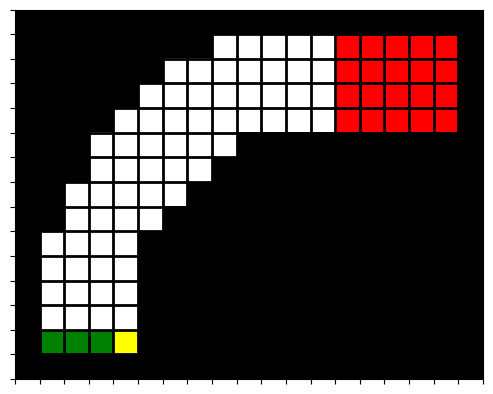

In [30]:
#Showing an untrained agent that is learning on the go
agent = newDynaP(0.05, 0.3, 0.5, 1.5)
visualise_race(agent)

In [19]:
#new DynaQ with priority sweep
modified_agent_rewards = []


#Params:alpha, epsilon, gamma, theta
agent = newDynaP(0.05, 0.3, 0.5, 1.5)

#Training for 150 episodes
for ep in range(0,150):
    state = env.reset()
    while(True):
        new_state, reward, end = agent.step(state, max(ep, 1000), ep)
        if(end):
            break
        state = new_state


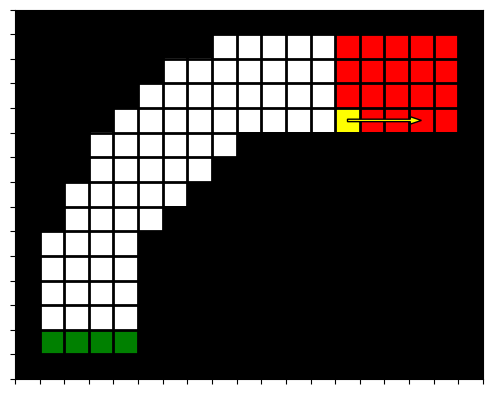

In [24]:
#Showing how my agent performs after 150 episodes of training  
visualise_race(agent)

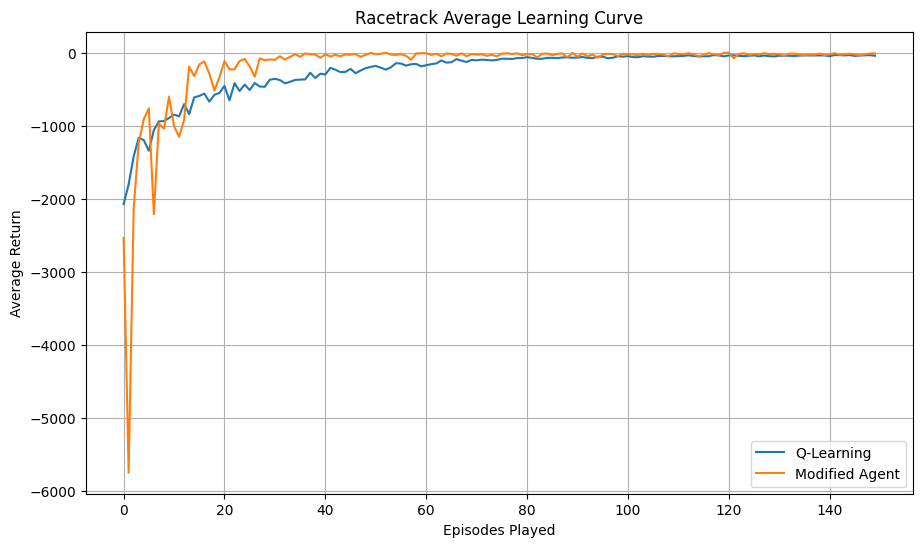

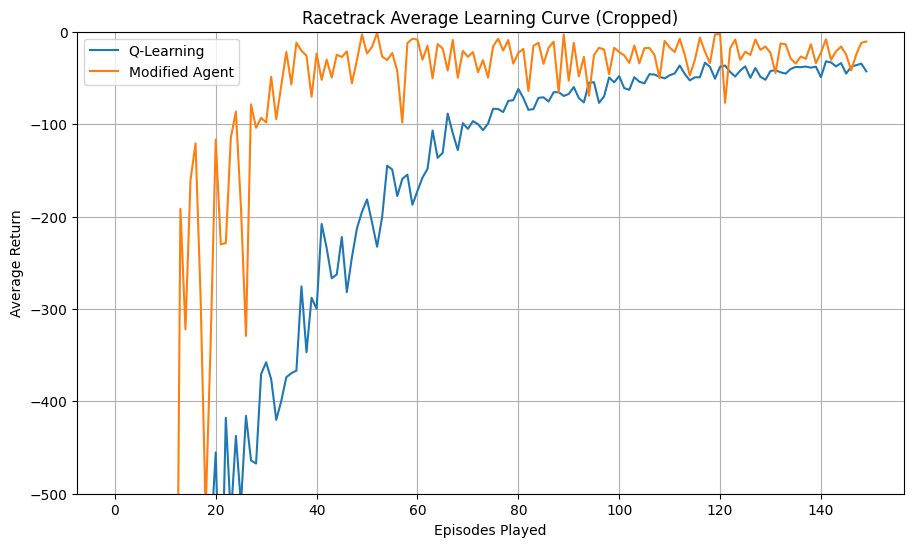

In [34]:
#This section of code is used to show the learning curve of the agent
#Benchmark is against a default but well-tuned Q-learning agent provided by a lecturer

from racetrack_env import plot_modified_agent_results
from racetrack_env import simple_issue_checking

modified_agent_rewards = []

#Training 5 agents to make learning curve smoother
for no_agents in range(0,5):
    agent = newDynaP(0.05, 0.3, 0.5, 1.5)
    agent_rewards = []
    for ep in range(0,150):
        state = env.reset()
        episode_reward = 0
        while(True):
            new_state, reward, end = agent.step(state, max(ep, 1000), ep)
            episode_reward+=reward
            if(end):
                agent_rewards.append(episode_reward)
                break
            state = new_state
    modified_agent_rewards.append(agent_rewards)


# Checking Modified Agent Results for Obvious Issues.
simple_issue_checking(modified_agent_rewards, modified_agent = True)

# Plotting Modified Agent Learning Curve.
%matplotlib inline
plot_modified_agent_results(modified_agent_rewards)